Deep Learning Fundamentals - Assignment 3 - RNN for Stock Price Prediction - Aman Sami - A1897314

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input, SimpleRNN
from keras.callbacks import EarlyStopping, Callback

In [2]:
train_df = pd.read_csv("/kaggle/input/gooogle-stock-price/Google_Stock_Price_Train.csv")
test_df  = pd.read_csv("/kaggle/input/gooogle-stock-price/Google_Stock_Price_Test.csv")

In [3]:
print("Train Dataset Head:")
print(train_df.head())

print("\nTest Dataset Head:")
print(test_df.head())

Train Dataset Head:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Test Dataset Head:
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


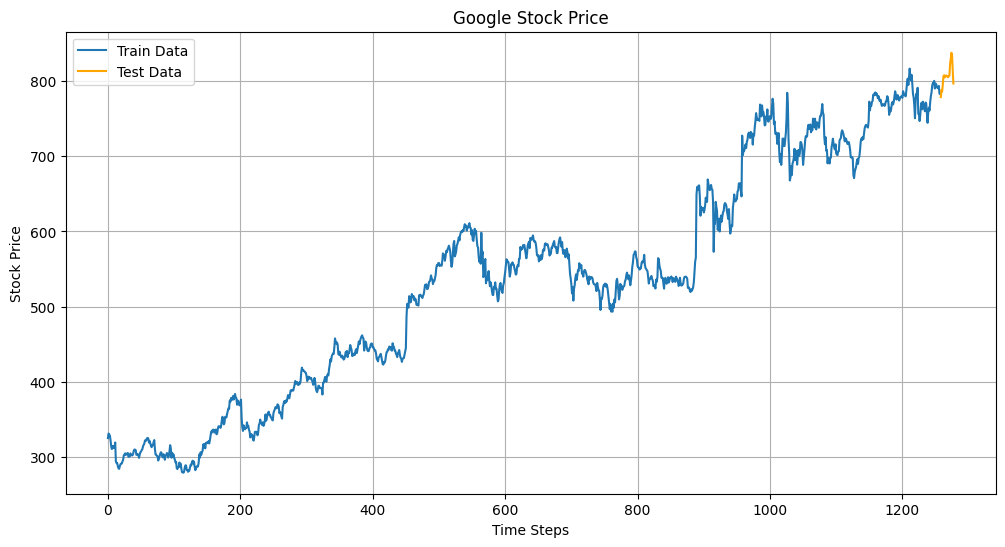

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Open'], label='Train Data')
plt.plot(np.arange(len(train_df), len(train_df) + len(test_df)), test_df['Open'], label='Test Data', color='orange')
plt.title("Google Stock Price")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()

In [5]:
def preprocess_data(df):
    if 'Date' in df.columns:
        df = df.drop(columns=['Date'])
    df = df.replace(',', '', regex=True).astype(float)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    return scaled_data, scaler

train_scaled, train_scaler = preprocess_data(train_df)
test_scaled, test_scaler = preprocess_data(test_df)
scaled_data = np.concatenate((train_scaled, test_scaled), axis=0)

In [6]:
def create_sliding_window(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N, :]) 
        y.append(data[i + N:i + N + M, :])
    return np.array(X), np.array(y)

N, M = 10, 5
split_index = len(train_scaled)
X_train, y_train = create_sliding_window(train_scaled, N, M)
X_test, y_test = create_sliding_window(test_scaled, N, M)

In [7]:
def train_lstm_baseline(X_train, y_train, X_val, y_val, N):
    model = Sequential([
        Input(shape=(N, 5)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(5)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train[:, 0, :],
        validation_data=(X_val, y_val[:, 0, :]),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

lstm_baseline_model, lstm_baseline_history = train_lstm_baseline(X_train, y_train, X_train, y_train, N)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1246 - mse: 0.1246 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mse:

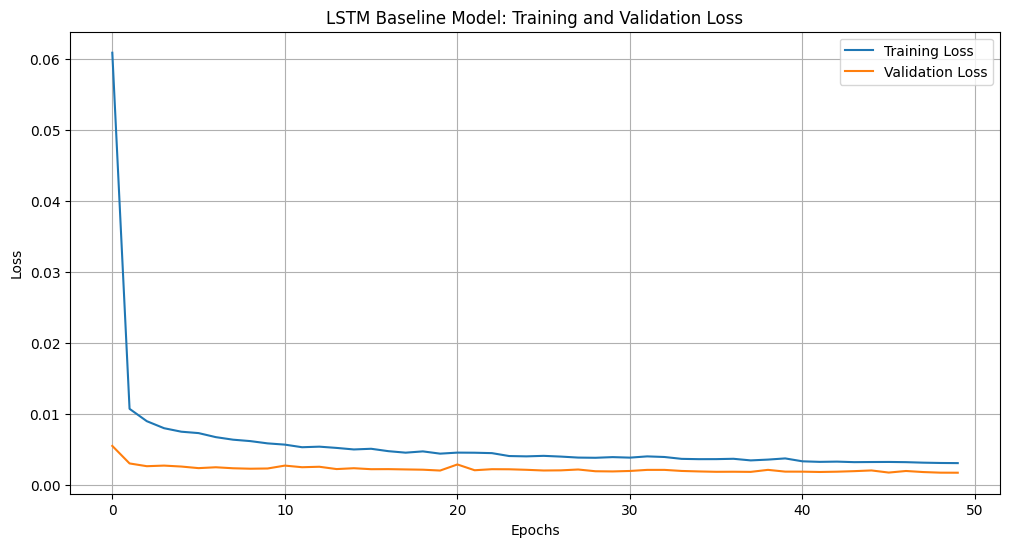

In [8]:
def plot_loss(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(lstm_baseline_history, 'LSTM Baseline Model: Training and Validation Loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


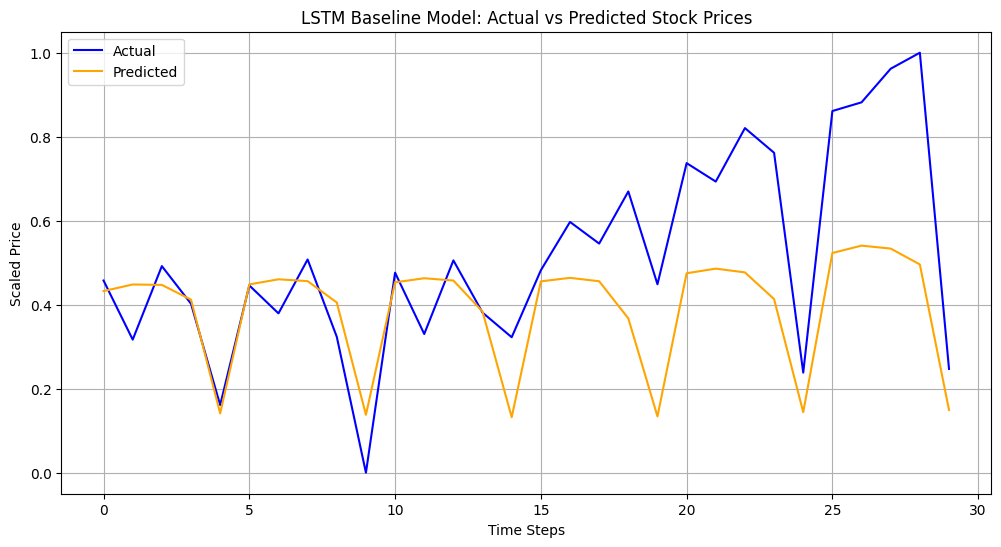

In [9]:
def plot_actual_vs_predicted(actual, predicted, title):
    actual_flat = actual[:, 0, :].flatten()
    predicted_flat = predicted.flatten()
    plt.figure(figsize=(12, 6))
    plt.plot(actual_flat, label='Actual', color='blue')
    plt.plot(predicted_flat, label='Predicted', color='orange')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.grid()
    plt.show()

lstm_predictions = lstm_baseline_model.predict(X_test)
plot_actual_vs_predicted(y_test, lstm_predictions, 'LSTM Baseline Model: Actual vs Predicted Stock Prices')

In [10]:
def train_vanilla_rnn_baseline(X_train, y_train, X_val, y_val, N):
    model = Sequential([
        Input(shape=(N, 5)),
        SimpleRNN(50, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(50, return_sequences=False),
        Dropout(0.2),
        Dense(5)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train[:, 0, :],
        validation_data=(X_val, y_val[:, 0, :]),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

vanilla_rnn_model, vanilla_rnn_history = train_vanilla_rnn_baseline(X_train, y_train, X_train, y_train, N)

Epoch 1/50


I0000 00:00:1733199256.216822     102 service.cc:145] XLA service 0x5c32d53672e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733199256.216874     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733199256.216878     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3008 - mse: 0.3008

I0000 00:00:1733199259.865297     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.2953 - mse: 0.2953 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0808 - mse: 0.0808 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0334 - mse: 0.0334 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - mse: 0.0146 -

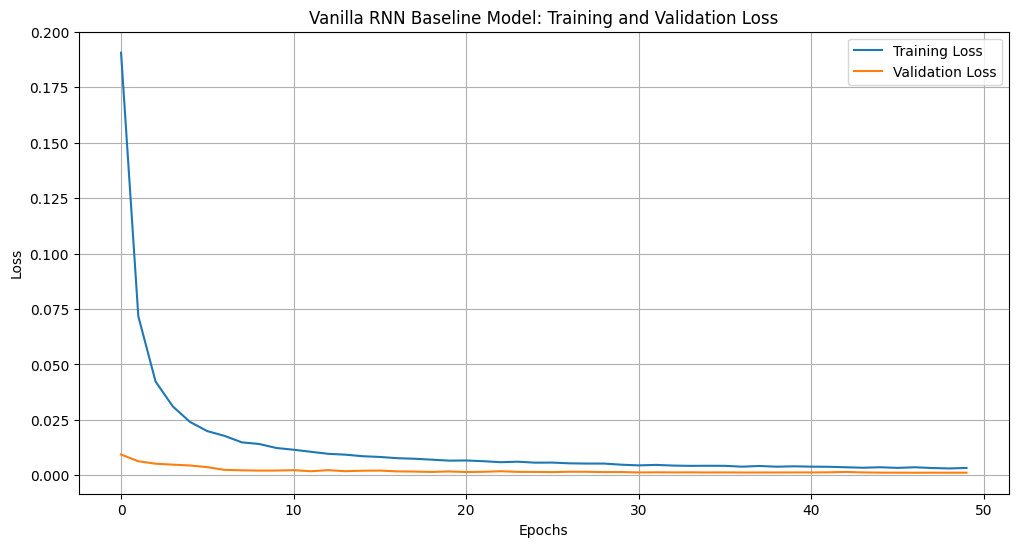

In [11]:
plot_loss(vanilla_rnn_history, 'Vanilla RNN Baseline Model: Training and Validation Loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


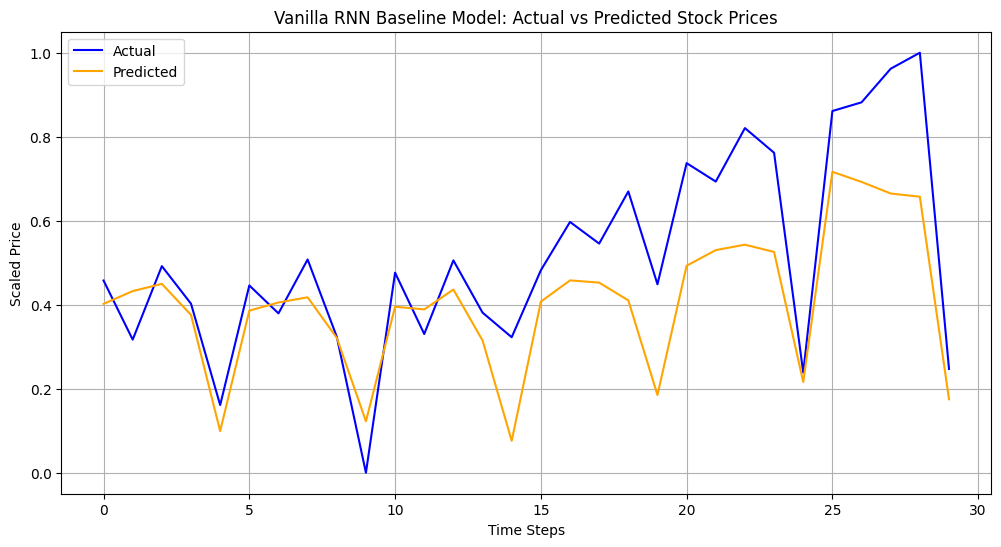

In [12]:
vanilla_rnn_predictions = vanilla_rnn_model.predict(X_test)
plot_actual_vs_predicted(y_test, vanilla_rnn_predictions, 'Vanilla RNN Baseline Model: Actual vs Predicted Stock Prices')

In [13]:
def tune_lstm_model(X_train, y_train, X_val, y_val):
    print("\n=== LSTM Model Hyperparameter Tuning ===")
    best_loss = float('inf')
    best_params = {}
    units_list = [50, 100]
    dropout_list = [0.2, 0.3]
    batch_size_list = [16, 32]
    results = []

    for units in units_list:
        for dropout in dropout_list:
            for batch_size in batch_size_list:
                print(f"\nTesting LSTM Parameters: Units={units}, Dropout={dropout}, Batch Size={batch_size}")
                model = Sequential([
                    Input(shape=(N, 5)),
                    LSTM(units, return_sequences=True),
                    Dropout(dropout),
                    LSTM(units, return_sequences=False),
                    Dropout(dropout),
                    Dense(5)
                ])
                model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                history = model.fit(
                    X_train, y_train[:, 0, :],
                    validation_data=(X_val, y_val[:, 0, :]),
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1  
                )

                val_loss = min(history.history['val_loss'])
                results.append({'units': units, 'dropout': dropout, 'batch_size': batch_size, 'val_loss': val_loss})
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = {'units': units, 'dropout': dropout, 'batch_size': batch_size, 'val_loss': val_loss}
                    best_model = model
    print(f"\nBest LSTM Parameters: {best_params}, Loss: {best_loss}")
    return best_model, best_params

lstm_best_model, lstm_best_params = tune_lstm_model(X_train, y_train, X_train, y_train)


=== LSTM Model Hyperparameter Tuning ===

Testing LSTM Parameters: Units=50, Dropout=0.2, Batch Size=16
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - mse: 0.0047 - v

In [14]:
def tune_vanilla_rnn_model(X_train, y_train, X_val, y_val):
    print("\n=== Vanilla RNN Model Hyperparameter Tuning ===")
    best_loss = float('inf')
    best_params = {}
    units_list = [50, 100]
    dropout_list = [0.2, 0.3]
    batch_size_list = [16, 32]
    results = []

    for units in units_list:
        for dropout in dropout_list:
            for batch_size in batch_size_list:
                print(f"\nTesting Vanilla RNN Parameters: Units={units}, Dropout={dropout}, Batch Size={batch_size}")
                model = Sequential([
                    Input(shape=(N, 5)),
                    SimpleRNN(units, return_sequences=True),
                    Dropout(dropout),
                    SimpleRNN(units, return_sequences=False),
                    Dropout(dropout),
                    Dense(5)
                ])
                model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                history = model.fit(
                    X_train, y_train[:, 0, :],
                    validation_data=(X_val, y_val[:, 0, :]),
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1  
                )

                val_loss = min(history.history['val_loss'])
                results.append({'units': units, 'dropout': dropout, 'batch_size': batch_size, 'val_loss': val_loss})
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = {'units': units, 'dropout': dropout, 'batch_size': batch_size, 'val_loss': val_loss}
                    best_model = model
    print(f"\nBest Vanilla RNN Parameters: {best_params}, Loss: {best_loss}")
    return best_model, best_params

vanilla_best_model, vanilla_best_params = tune_vanilla_rnn_model(X_train, y_train, X_train, y_train)


=== Vanilla RNN Model Hyperparameter Tuning ===

Testing Vanilla RNN Parameters: Units=50, Dropout=0.2, Batch Size=16
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.2172 - mse: 0.2172 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - m

In [15]:
if lstm_best_params['val_loss'] < vanilla_best_params['val_loss']:
    best_model_type = 'LSTM'
    best_model = lstm_best_model
    best_params = lstm_best_params
else:
    best_model_type = 'Vanilla RNN'
    best_model = vanilla_best_model
    best_params = vanilla_best_params

print(f"\nThe best model is: {best_model_type} with parameters {best_params}")


The best model is: Vanilla RNN with parameters {'units': 100, 'dropout': 0.2, 'batch_size': 16, 'val_loss': 0.0013532777084037662}


In [16]:
def retrain_best_model(X_train, y_train, X_val, y_val, N, best_model_type, best_params):
    print(f"\nRetraining the best model: {best_model_type} with parameters {best_params}")
    model = Sequential([
        Input(shape=(N, 5)),
        (LSTM(best_params['units'], return_sequences=True) if best_model_type == 'LSTM' else SimpleRNN(best_params['units'], return_sequences=True)),
        Dropout(best_params['dropout']),
        (LSTM(best_params['units'], return_sequences=False) if best_model_type == 'LSTM' else SimpleRNN(best_params['units'], return_sequences=False)),
        Dropout(best_params['dropout']),
        Dense(5)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train[:, 0, :],
        validation_data=(X_val, y_val[:, 0, :]),
        epochs=50,
        batch_size=best_params['batch_size'],
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

final_model, final_history = retrain_best_model(X_train, y_train, X_train, y_train, N, best_model_type, best_params)


Retraining the best model: Vanilla RNN with parameters {'units': 100, 'dropout': 0.2, 'batch_size': 16, 'val_loss': 0.0013532777084037662}
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.2618 - mse: 0.2618 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

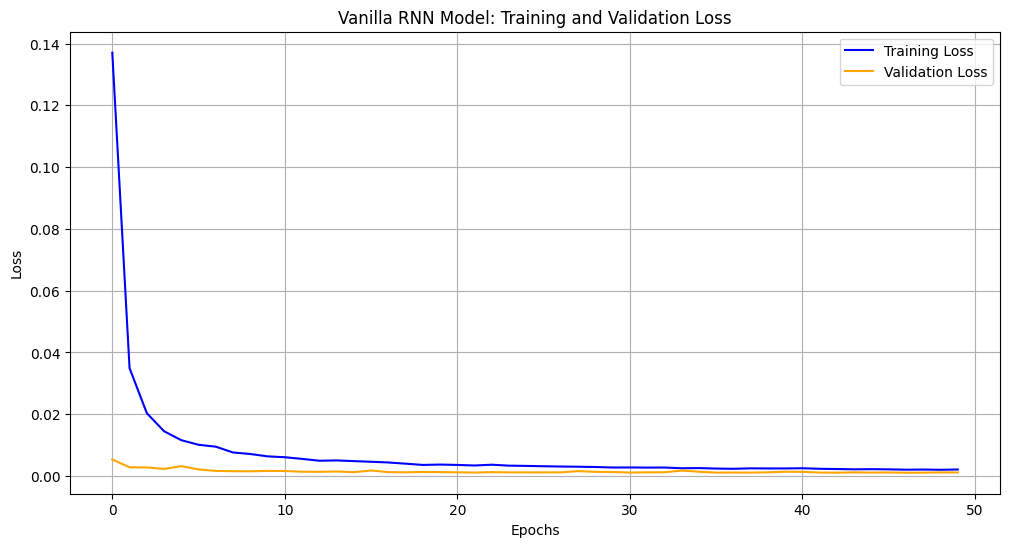

In [17]:
def plot_loss_curve(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curve(final_history, f"{best_model_type} Model: Training and Validation Loss")


Evaluating Best Model on Test Data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


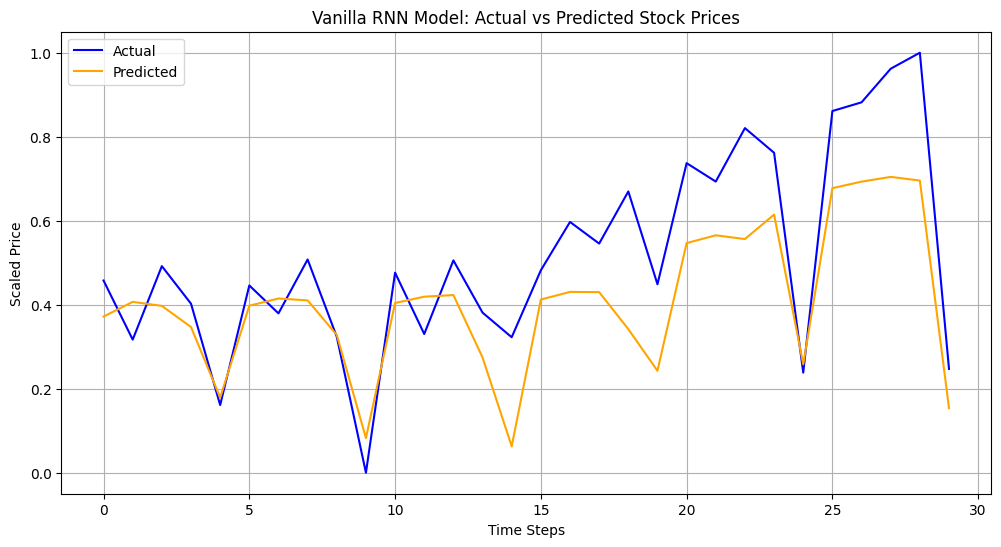

In [18]:
def plot_actual_vs_predicted(actual, predicted, title):
    actual_flat = actual[:, 0, :].flatten()
    predicted_flat = predicted.flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(actual_flat, label='Actual', color='blue')
    plt.plot(predicted_flat, label='Predicted', color='orange')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.grid()
    plt.show()

print("\nEvaluating Best Model on Test Data...")
predictions = final_model.predict(X_test)
plot_actual_vs_predicted(y_test, predictions, f"{best_model_type} Model: Actual vs Predicted Stock Prices")

The Workflow of the project was refered from various sources as listed below

[1] I acknowledge the use of ChatGPT [https://chat.openai.com/] and ChatGPT Custom Model to generate ideas and material for background research and project planning in the drafting of this assignment. The following prompts were entered into ChatGPT on 20th October 2024:

1. Best Models to choose for RNN Stock Price Prediction
2. Code Workflow for RNN Stock Price Prediction
3. Plot Interpretation

[2] https://www.kaggle.com/code/nexuswho/lstm-predictions

[3] https://www.kaggle.com/code/bilrein/rnn-google-stock-price

[4] https://www.kaggle.com/code/itsakphyo/rnn-vs-gru-on-google-stock-prediction

[5] https://www.kaggle.com/code/bhupendersharma999/google-stock-price-prediction-rnn